# =============================================================
# MILESTONE 2: Advanced Data Analysis and Feature Engineering
# =============================================================

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go



In [ ]:
# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# === 1. Initial Setup and Data Cleaning ===

In [33]:
url = "https://raw.githubusercontent.com/Reemsoliiman/customer-churn-prediction-analysis/main/data/interim/initial_cleaned_data.csv"
df = pd.read_csv(url)

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded: 3333 rows, 77 columns


In [34]:
# Define features (X) and target (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

In [35]:
charge_columns = ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']
X = X.drop(columns=charge_columns, errors='ignore')
print(f"Dropped charge columns to mitigate multicollinearity: {charge_columns}")

Dropped charge columns to mitigate multicollinearity: ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']


# === 2. Feature Engineering ===

In [ ]:
# 2.1 Tenure ( 'Account length' is already in months; rename for clarity)
X = X.rename(columns={'Account length': 'Customer tenure'})

In [37]:
# 2.2 Average Daily Usage
X['Avg_Daily_Usage'] = (X['Total day minutes'] + X['Total eve minutes'] + X['Total night minutes']) / X['Customer tenure']

In [38]:
# 2.3 Total Calls
call_columns = ['Total day calls', 'Total eve calls', 'Total night calls', 'Total intl calls']
X['Total_Calls'] = X[call_columns].sum(axis=1)

In [39]:
# 2.4 Identify categorical and numerical features
cat_features = ['State', 'International plan', 'Voice mail plan'] + [col for col in X.columns if col.startswith('State_')]
num_features = [col for col in X.columns if col not in cat_features]
print(f"Categorical features: {cat_features}")
print(f"Numerical features: {num_features}")

Categorical features: ['State', 'International plan', 'Voice mail plan', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY']
Numerical features: ['Customer tenure', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total eve minutes', 'Total eve calls', 'Total night minutes', 'Total night calls', 'Total intl minutes', 'Total intl calls', 'Customer service calls', 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'Hi

# === 3. Advanced Data Analysis & Statistical Testing ===

In [40]:
# 3.1 Chi-Squared Test for categorical features
print("\n=== Chi-Squared Test Results for Categorical Features ===")
for feature in cat_features:
    if feature in X.columns:
        contingency_table = pd.crosstab(X[feature], y)
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        print(f"{feature}: Chi2 = {chi2:.2f}, p-value = {p:.4f} {'(Significant)' if p < 0.05 else ''}")


=== Chi-Squared Test Results for Categorical Features ===
State_AL: Chi2 = 0.99, p-value = 0.3200 
State_AR: Chi2 = 0.95, p-value = 0.3285 
State_AZ: Chi2 = 2.93, p-value = 0.0869 
State_CA: Chi2 = 3.06, p-value = 0.0802 
State_CO: Chi2 = 0.00, p-value = 0.9819 
State_CT: Chi2 = 0.07, p-value = 0.7954 
State_DC: Chi2 = 0.82, p-value = 0.3648 
State_DE: Chi2 = 0.00, p-value = 1.0000 
State_FL: Chi2 = 0.05, p-value = 0.8200 
State_GA: Chi2 = 0.00, p-value = 1.0000 
State_HI: Chi2 = 2.70, p-value = 0.1001 
State_IA: Chi2 = 1.54, p-value = 0.2150 
State_ID: Chi2 = 0.13, p-value = 0.7169 
State_IL: Chi2 = 1.20, p-value = 0.2743 
State_IN: Chi2 = 0.07, p-value = 0.7880 
State_KS: Chi2 = 0.65, p-value = 0.4188 
State_KY: Chi2 = 0.00, p-value = 0.9851 
State_LA: Chi2 = 1.34, p-value = 0.2466 
State_MA: Chi2 = 0.15, p-value = 0.7006 
State_MD: Chi2 = 4.76, p-value = 0.0292 (Significant)
State_ME: Chi2 = 1.64, p-value = 0.2005 
State_MI: Chi2 = 2.74, p-value = 0.0980 
State_MN: Chi2 = 0.53, p-v

In [41]:
# 3.2 T-test for numerical features
print("\n=== T-test Results for Numerical Features ===")
for feature in num_features:
    if feature in X.columns:
        churned = X[y == True][feature]
        not_churned = X[y == False][feature]
        t_stat, p_val = stats.ttest_ind(churned, not_churned, equal_var=False)
        print(f"{feature}: t-stat = {t_stat:.2f}, p-value = {p_val:.4f} {'(Significant)' if p_val < 0.05 else ''}")


=== T-test Results for Numerical Features ===
Customer tenure: t-stat = 0.95, p-value = 0.3433 
Number vmail messages: t-stat = -5.82, p-value = 0.0000 (Significant)
Total day minutes: t-stat = 9.70, p-value = 0.0000 (Significant)
Total day calls: t-stat = 1.00, p-value = 0.3165 
Total eve minutes: t-stat = 5.23, p-value = 0.0000 (Significant)
Total eve calls: t-stat = 0.54, p-value = 0.5912 
Total night minutes: t-stat = 2.20, p-value = 0.0278 (Significant)
Total night calls: t-stat = 0.35, p-value = 0.7273 
Total intl minutes: t-stat = 3.79, p-value = 0.0002 (Significant)
Total intl calls: t-stat = -2.96, p-value = 0.0032 (Significant)
Customer service calls: t-stat = 8.96, p-value = 0.0000 (Significant)
Total_Charge: t-stat = 10.52, p-value = 0.0000 (Significant)
Total_Minutes: t-stat = 9.61, p-value = 0.0000 (Significant)
Avg_Minute_Cost: t-stat = 5.71, p-value = 0.0000 (Significant)
Total_Calls: t-stat = 0.90, p-value = 0.3709 
High_Customer_Service: t-stat = 11.48, p-value = 0.0

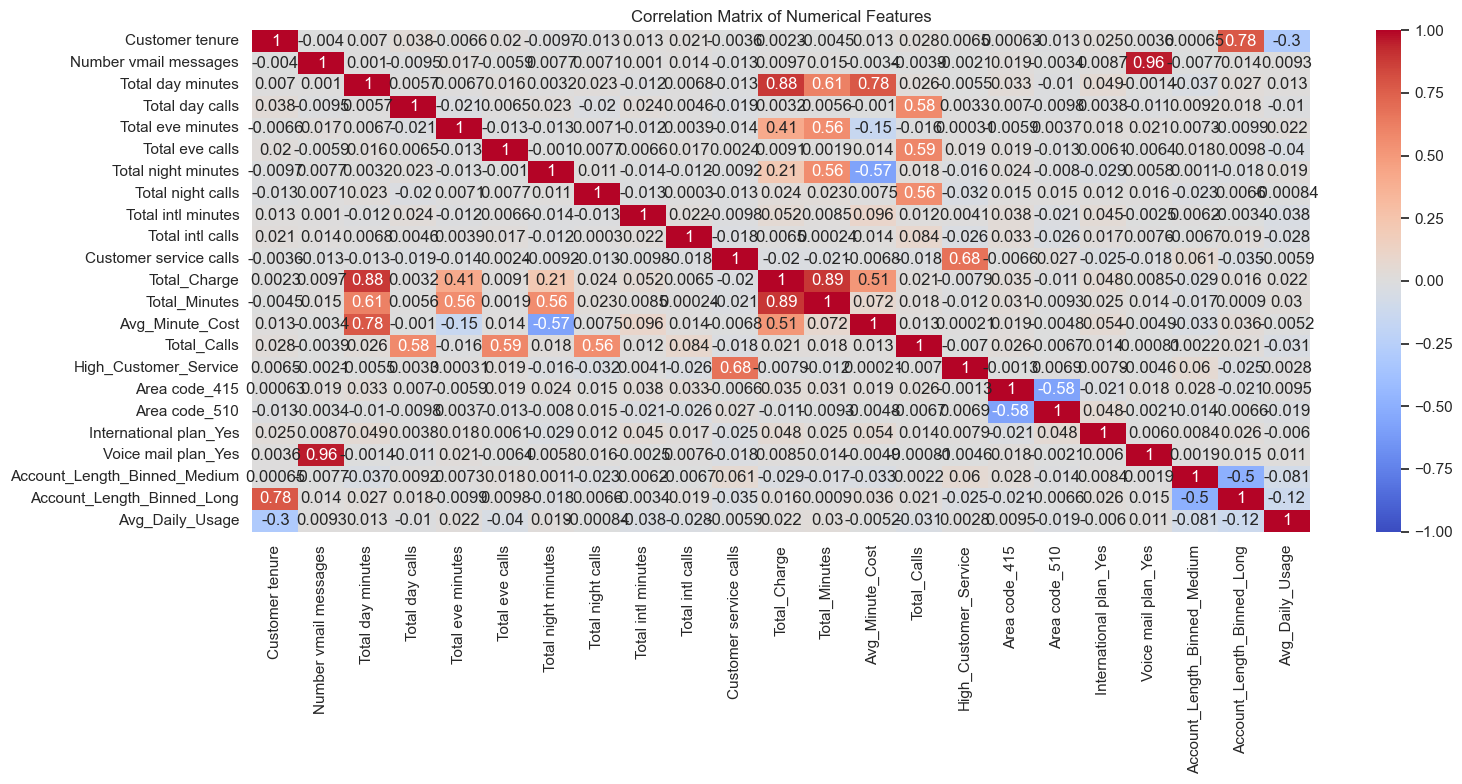

In [44]:
# 3.3 Correlation Matrix for numerical features
plt.figure(figsize=(16, 8))
sns.heatmap(X[num_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
output_dir = "../visualizations/enhanced"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "correlation_matrix.png"))
plt.show()

# === 4. Feature Processing and Selection ===

In [45]:
# 4.1 Split data to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")

Training set: 2666 rows, Test set: 667 rows


# ========================
# 1. Statistical Tests
# ========================

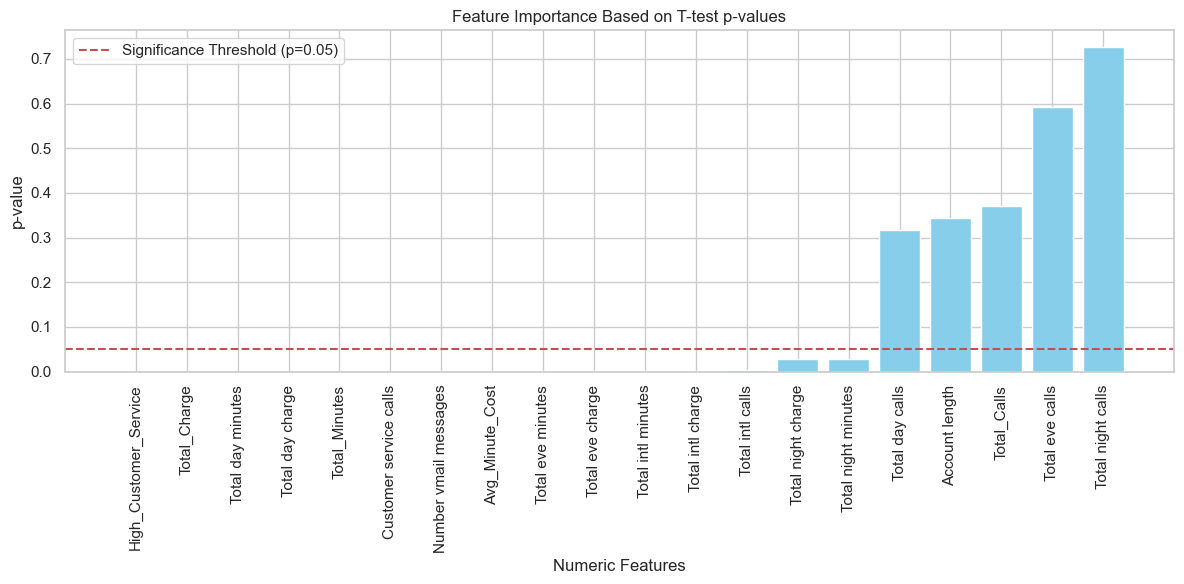

T-test p-values ordered by importance (lowest to highest):
High_Customer_Service: p-value = 0.0000
Total_Charge: p-value = 0.0000
Total day minutes: p-value = 0.0000
Total day charge: p-value = 0.0000
Total_Minutes: p-value = 0.0000
Customer service calls: p-value = 0.0000
Number vmail messages: p-value = 0.0000
Avg_Minute_Cost: p-value = 0.0000
Total eve minutes: p-value = 0.0000
Total eve charge: p-value = 0.0000
Total intl minutes: p-value = 0.0002
Total intl charge: p-value = 0.0002
Total intl calls: p-value = 0.0032
Total night charge: p-value = 0.0278
Total night minutes: p-value = 0.0278
Total day calls: p-value = 0.3165
Account length: p-value = 0.3433
Total_Calls: p-value = 0.3709
Total eve calls: p-value = 0.5912
Total night calls: p-value = 0.7273

Significant features (p < 0.05):
High_Customer_Service: p-value = 0.0000
Total_Charge: p-value = 0.0000
Total day minutes: p-value = 0.0000
Total day charge: p-value = 0.0000
Total_Minutes: p-value = 0.0000
Customer service calls:

In [4]:
## T-test for Numeric Features

# Identify numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns
target = 'Churn'

# Perform t-tests for each numeric feature
t_test_results = {}
for feature in numeric_features:
    if feature != target:  # Exclude the target variable
        group1 = df[df[target] == False][feature].dropna()
        group2 = df[df[target] == True][feature].dropna()
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        t_test_results[feature] = p_value

# Sort features by p-value
sorted_results = dict(sorted(t_test_results.items(), key=lambda x: x[1]))

# Prepare data for visualization
features = list(sorted_results.keys())
p_values = list(sorted_results.values())

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(features, p_values, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Numeric Features')
plt.ylabel('p-value')
plt.title('Feature Importance Based on T-test p-values')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/feature_importance_based_on_T-test_p-values.png')
plt.show()

# Display results
print("T-test p-values ordered by importance (lowest to highest):")
for feature, p_value in sorted_results.items():
    print(f"{feature}: p-value = {p_value:.4f}")

# Highlight significant features (p < 0.05)
significant_features_ttest = {k: v for k, v in sorted_results.items() if v < 0.05}
print("\nSignificant features (p < 0.05):")
for feature, p_value in significant_features_ttest.items():
    print(f"{feature}: p-value = {p_value:.4f}")



Chi-squared Test Results:


,Feature,Chi2,p-value
52,International plan_Yes,222.565757,2.493108e-50
53,Voice mail plan_Yes,34.131660,5.150640e-09
30,State_NJ,7.082219,7.785253e-03
42,State_TX,5.720015,1.677259e-02
19,State_MD,4.757345,2.917352e-02
44,State_VA,3.435014,6.382803e-02
39,State_SC,3.162475,7.534888e-02
3,State_CA,3.061232,8.018087e-02
2,State_AZ,2.930757,8.690672e-02
21,State_MI,2.737304,9.803006e-02



Significant Features (p < 0.05):


,Feature,Chi2,p-value
52,International plan_Yes,222.565757,2.493108e-50
53,Voice mail plan_Yes,34.131660,5.150640e-09
30,State_NJ,7.082219,7.785253e-03
42,State_TX,5.720015,1.677259e-02
19,State_MD,4.757345,2.917352e-02


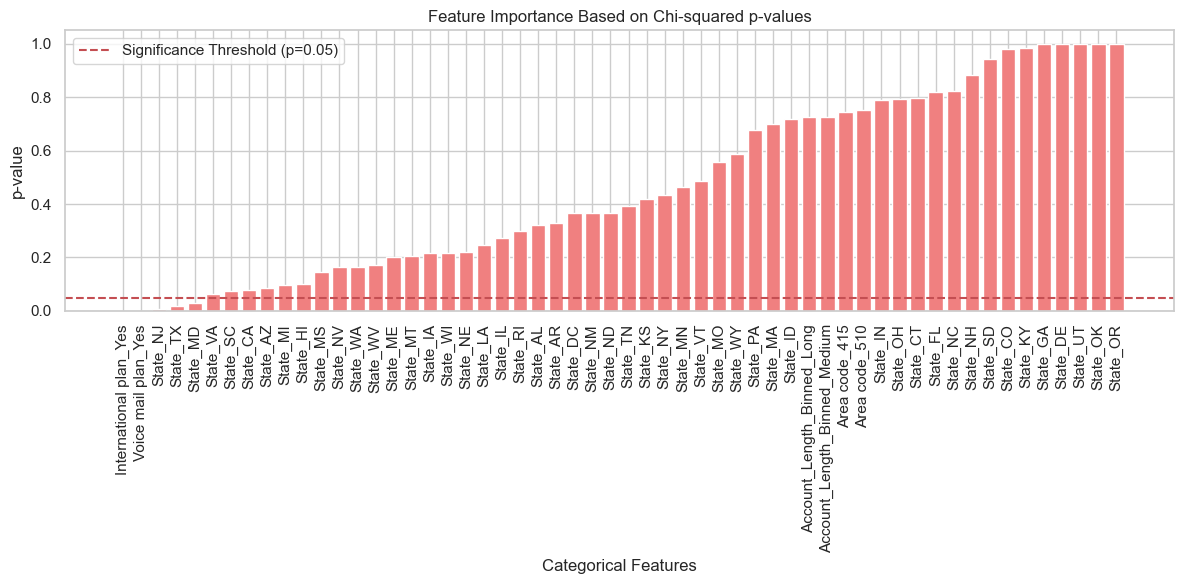

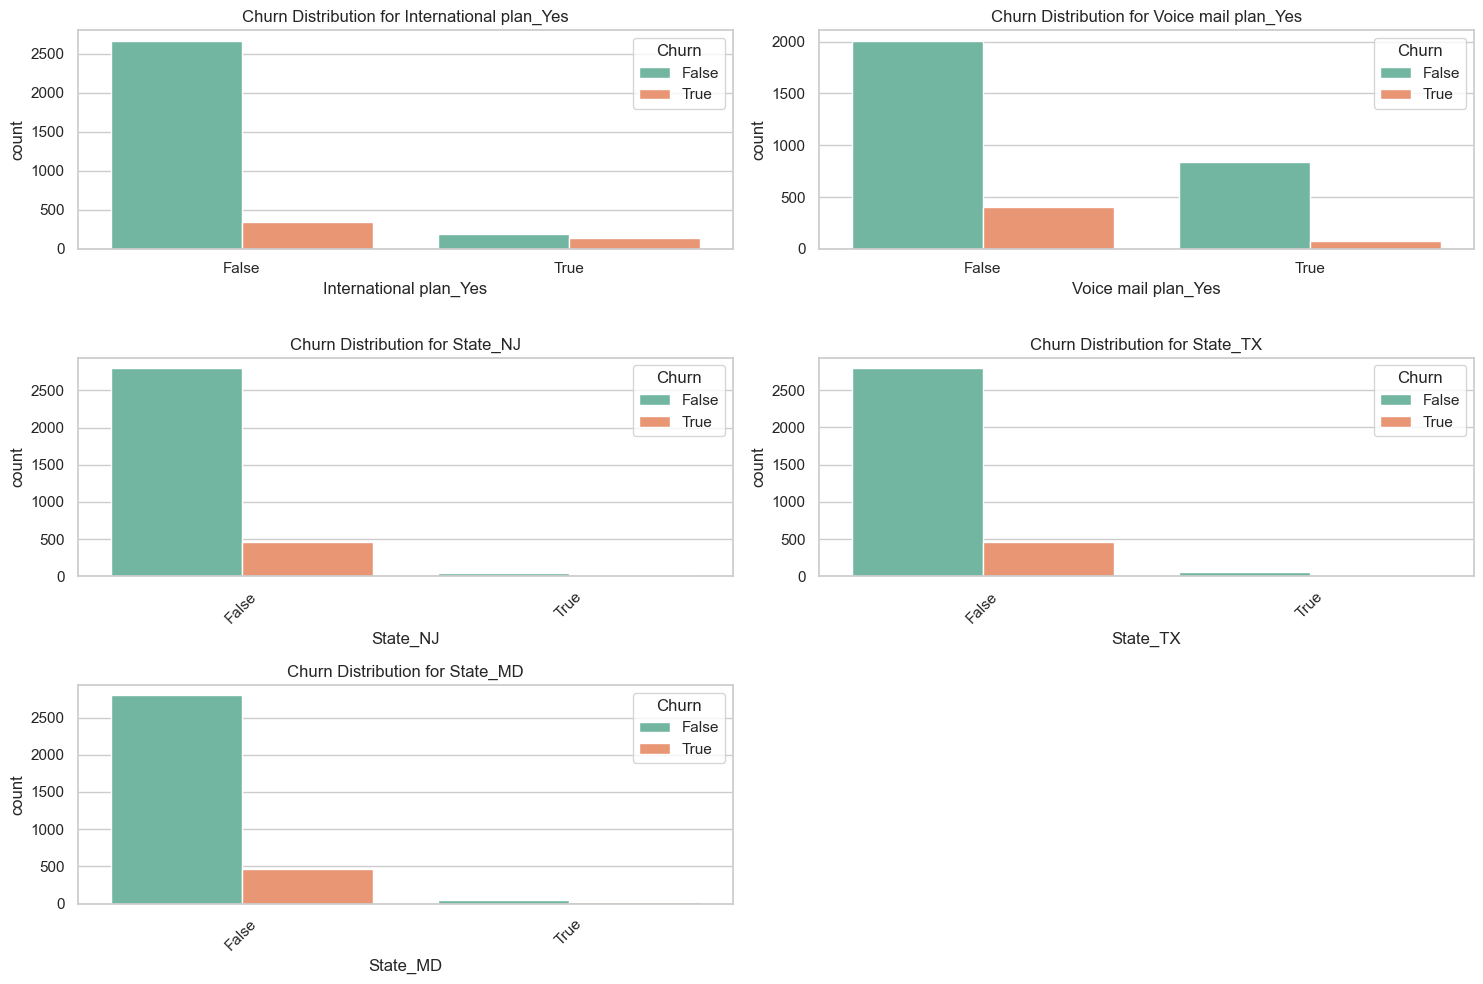

International plan_Yes: p-value=0.0000 --> Significant
Voice mail plan_Yes: p-value=0.0000 --> Significant
State_NJ: p-value=0.0078 --> Significant
State_TX: p-value=0.0168 --> Significant
State_MD: p-value=0.0292 --> Significant
State_VA: p-value=0.0638 --> Not Significant
State_SC: p-value=0.0753 --> Not Significant
State_CA: p-value=0.0802 --> Not Significant
State_AZ: p-value=0.0869 --> Not Significant
State_MI: p-value=0.0980 --> Not Significant
State_HI: p-value=0.1001 --> Not Significant
State_MS: p-value=0.1465 --> Not Significant
State_NV: p-value=0.1645 --> Not Significant
State_WA: p-value=0.1645 --> Not Significant
State_WV: p-value=0.1729 --> Not Significant
State_ME: p-value=0.2005 --> Not Significant
State_MT: p-value=0.2044 --> Not Significant
State_IA: p-value=0.2150 --> Not Significant
State_WI: p-value=0.2157 --> Not Significant
State_NE: p-value=0.2202 --> Not Significant
State_LA: p-value=0.2466 --> Not Significant
State_IL: p-value=0.2743 --> Not Significant
State

In [5]:
## Chi-Square Test for Categorical Features

# Define categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = [col for col in df.columns if col not in numeric_cols]
target = 'Churn'

# Perform Chi-squared tests
chi2_results = []
for col in categorical_cols:
    if col != target: 
        contingency_table = pd.crosstab(df[col], df[target])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        chi2_results.append({"Feature": col, "Chi2": chi2, "p-value": p})

# Convert to DataFrame and sort by p-value
chi2_df = pd.DataFrame(chi2_results).sort_values("p-value")

# Display results
print("\nChi-squared Test Results:")
display(chi2_df)

# Highlight significant features (p < 0.05)
significant_features_chi2 = chi2_df[chi2_df['p-value'] < 0.05]
print("\nSignificant Features (p < 0.05):")
display(significant_features_chi2)

# Visualize feature importance with bar chart
plt.figure(figsize=(12, 6))
plt.bar(chi2_df['Feature'], chi2_df['p-value'], color='lightcoral')
plt.xticks(rotation=90)
plt.xlabel('Categorical Features')
plt.ylabel('p-value')
plt.title('Feature Importance Based on Chi-squared p-values')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/feature_importance_based_on_Chi-squared_p-values.png')
plt.show()

# Additional visualization: Countplot for significant features
plt.figure(figsize=(15, 10))
n_cols = 2
n_rows = int(np.ceil(len(significant_features_chi2) / n_cols))
for i, row in enumerate(significant_features_chi2.itertuples(), 1):
    col = row.Feature
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=df, x=col, hue=target, palette='Set2')
    plt.title(f'Churn Distribution for {col}')
    plt.xticks(rotation=45 if 'State' in col else 0)
    plt.legend(title='Churn', labels=['False', 'True'])
plt.tight_layout()
plt.savefig('../visualizations/enhanced/countplot_significant_features.png')
plt.show()

# Print significance status for each feature
for i, row in chi2_df.iterrows():
    signif = "Significant" if row["p-value"] < 0.05 else "Not Significant"
    print(f"{row['Feature']}: p-value={row['p-value']:.4f} --> {signif}")

In [6]:
## Summarize Significant Features
# Combine significant features from t-tests and chi-square tests
significant_features = pd.concat([
    pd.DataFrame({
        'Feature': list(significant_features_ttest.keys()),
        'Test': 'T-test',
        'P-Value': list(significant_features_ttest.values())
    }),
    chi2_df[chi2_df['p-value'] < 0.05][['Feature', 'p-value']].rename(columns={'p-value': 'P-Value'}).assign(Test='Chi-Square')
]).reset_index(drop=True)
significant_features['P-Value'] = significant_features['P-Value'].round(4)

# Display summary
print("\nSummary of Significant Features (p < 0.05):")
display(significant_features)


Summary of Significant Features (p < 0.05):


,Feature,Test,P-Value
0,High_Customer_Service,T-test,0.0000
1,Total_Charge,T-test,0.0000
2,Total day minutes,T-test,0.0000
3,Total day charge,T-test,0.0000
4,Total_Minutes,T-test,0.0000
5,Customer service calls,T-test,0.0000
6,Number vmail messages,T-test,0.0000
7,Avg_Minute_Cost,T-test,0.0000
8,Total eve minutes,T-test,0.0000
9,Total eve charge,T-test,0.0000


In [7]:
print(df.columns.tolist())

['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn', 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'Sta


Mean Values for Significant Numeric Features:


,Non-Churned,Churned
High_Customer_Service,0.05,0.29
Total_Charge,58.47,65.32
Total day minutes,175.25,206.75
Total day charge,29.79,35.15
Total_Minutes,584.61,634.96
Customer service calls,1.45,2.23
Number vmail messages,8.60,5.12
Avg_Minute_Cost,0.10,0.10
Total eve minutes,199.10,212.28
Total eve charge,16.92,18.04


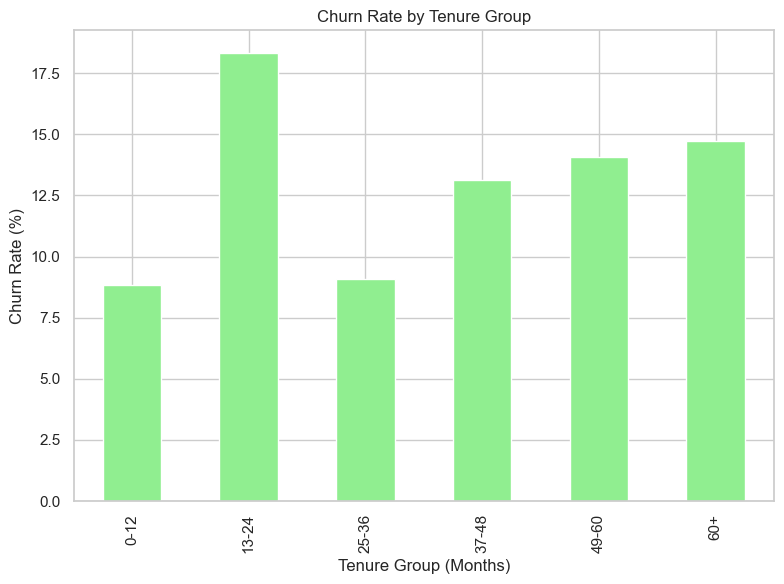

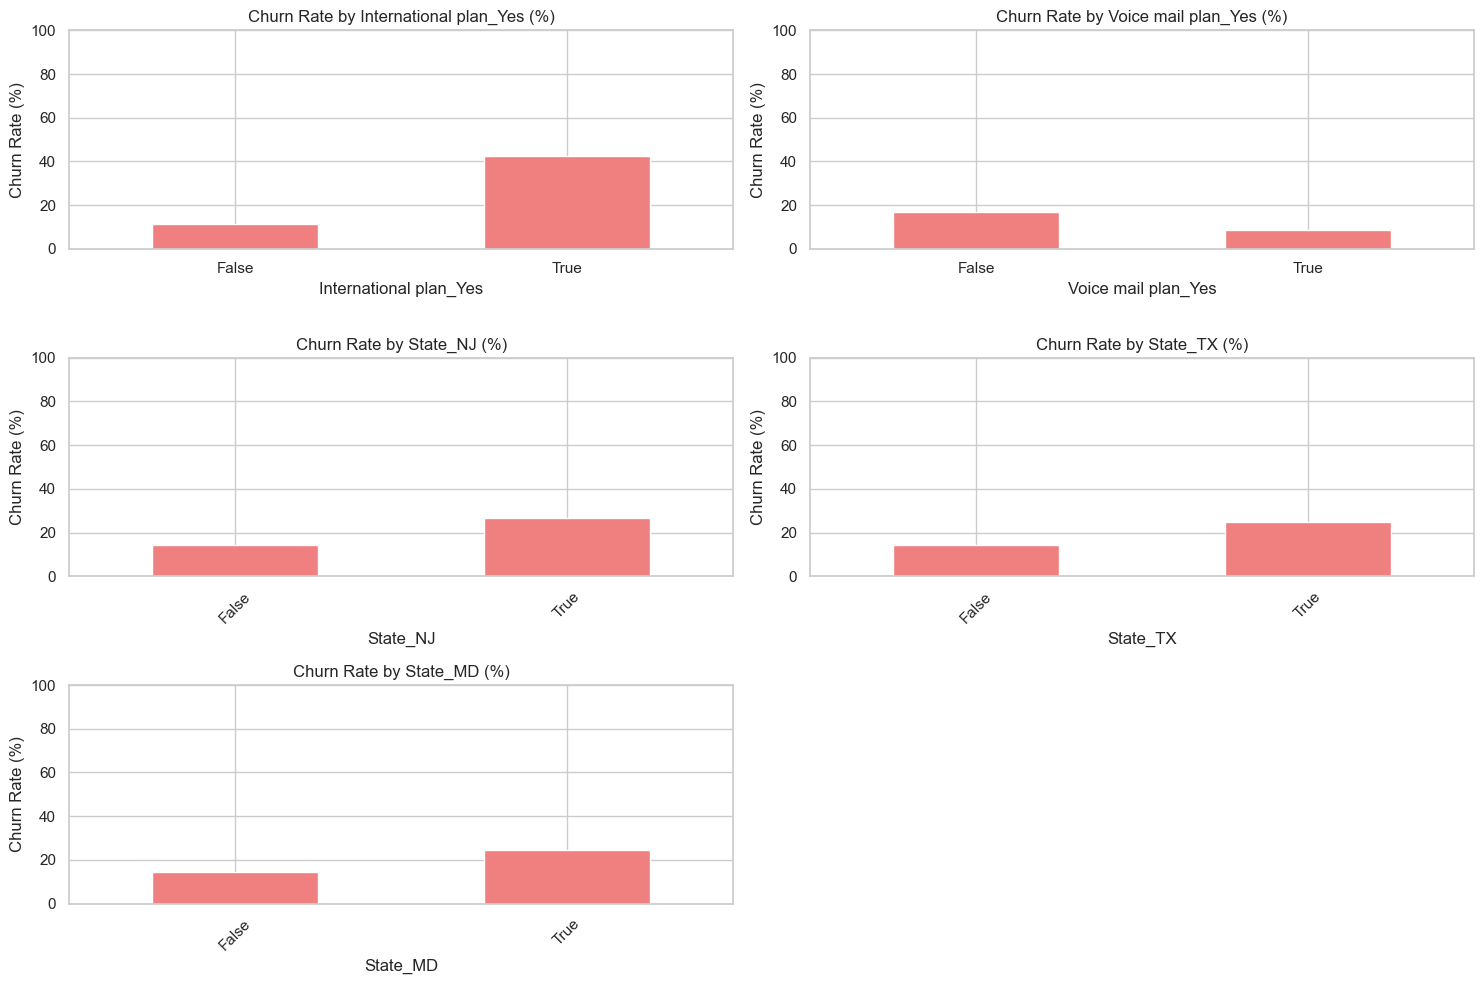

In [8]:
## Highlight Key Patterns

# Mean values for significant numeric features
significant_numeric = significant_features[significant_features['Test'] == 'T-test']['Feature'].tolist()
mean_by_churn = df.groupby('Churn')[significant_numeric].mean().round(2).T
mean_by_churn.columns = ['Non-Churned', 'Churned']

# Churn rate by tenure group
tenure_groups = pd.cut(df['Account length'], bins=[0, 12, 24, 36, 48, 60, float('inf')], 
                       labels=['0-12', '13-24', '25-36', '37-48', '49-60', '60+'])
churn_rate_by_tenure = df.groupby(tenure_groups, observed=True)['Churn'].mean().round(4) * 100

# Churn rate by significant categorical features
significant_categorical = significant_features[significant_features['Test'] == 'Chi-Square']['Feature'].tolist()
churn_rate_by_categorical = {col: df.groupby(col)['Churn'].mean().round(4) * 100 for col in significant_categorical}

# Display key patterns
print("\nMean Values for Significant Numeric Features:")
display(mean_by_churn)
# print("\nChurn Rate by Tenure Group (%):")
# display(churn_rate_by_tenure)
# print("\nChurn Rate by Significant Categorical Features (%):")
# for col, rates in churn_rate_by_categorical.items():
#     print(f"\n{col}:")
#     display(rates)

# Visualize churn rate by tenure
plt.figure(figsize=(8, 6))
churn_rate_by_tenure.plot(kind='bar', color='lightgreen')
plt.xlabel('Tenure Group (Months)')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Tenure Group')
plt.tight_layout()
plt.savefig('../visualizations/enhanced/churn_rate_by_tenure.png')
plt.show()

## Visualize Churn Rate by Significant Categorical Features 
plt.figure(figsize=(15, 10))
n_cols = 2
n_rows = int(np.ceil(len(significant_categorical) / n_cols))
for i, col in enumerate(significant_categorical, 1):
    plt.subplot(n_rows, n_cols, i)
    churn_rate = df.groupby(col)['Churn'].mean().round(4) * 100
    churn_rate.plot(kind='bar', color='lightcoral')
    plt.title(f'Churn Rate by {col} (%)')
    plt.xlabel(col)
    plt.ylabel('Churn Rate (%)')
    plt.xticks(rotation=45 if 'State' in col else 0)
    plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('../visualizations/enhanced/churn_rate_by_categorical.png')
plt.show()

In [9]:
## Address Non-Significant Features

# Non-significant features from t-tests
non_significant_ttest = {k: v for k, v in sorted_results.items() if v >= 0.05}
non_significant_chi2 = chi2_df[chi2_df['p-value'] >= 0.05][['Feature', 'p-value']].rename(columns={'p-value': 'P-Value'})

# Combine non-significant features
non_significant_features = pd.concat([
    pd.DataFrame({
        'Feature': list(non_significant_ttest.keys()),
        'Test': 'T-test',
        'P-Value': list(non_significant_ttest.values())
    }),
    non_significant_chi2.assign(Test='Chi-Square')
]).reset_index(drop=True)
non_significant_features['P-Value'] = non_significant_features['P-Value'].round(4)

# Display non-significant features
print("\nNon-Significant Features (p >= 0.05):")
display(non_significant_features)


Non-Significant Features (p >= 0.05):


,Feature,Test,P-Value
0,Total day calls,T-test,0.3165
1,Account length,T-test,0.3433
2,Total_Calls,T-test,0.3709
3,Total eve calls,T-test,0.5912
4,Total night calls,T-test,0.7273
5,State_VA,Chi-Square,0.0638
6,State_SC,Chi-Square,0.0753
7,State_CA,Chi-Square,0.0802
8,State_AZ,Chi-Square,0.0869
9,State_MI,Chi-Square,0.0980


In [13]:
# ## Correlation Matrix for Numeric Features

# # Define numeric features from statistical test results
# numeric_features = df.select_dtypes(include=[np.number]).columns

# # Compute correlation matrix
# corr_matrix = df[numeric_features].corr(method='pearson')

# # Visualize correlation matrix
# plt.figure(figsize=(16, 10))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
# plt.title('Correlation Matrix of Numeric Features')
# plt.tight_layout()
# plt.savefig('../visualizations/enhanced/correlation_matrix.png')
# plt.show()

# # Identify highly correlated pairs (|correlation| > 0.7)
# high_corr_pairs = []
# for i in range(len(corr_matrix.columns)):
#     for j in range(i + 1, len(corr_matrix.columns)):
#         if abs(corr_matrix.iloc[i, j]) > 0.7:
#             high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
# for pair in high_corr_pairs:
#     print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

In [14]:
## Handle Multicollinearity

# List of features to drop due to high correlations (> 0.7)
features_to_drop = [
    'Account length', # redundant with Customer tenure, non-significant
    'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', # derived from minutes
    'High service calls', # redundant with High_Customer_Service
    'log_average_minutes_per_call',  # redundant with Average minutes per call
    'Calls per tenure', # redundant with Average calls per day
    'Total_Minutes', 'log_total_minutes', # redundant with Total_Charge
    'log_average_daily_usage', # non-significant, correlated with Account length
    'average daily usage', # non-significant, correlated with Average calls per day
    'Avg_Minute_Cost' # less significant than Total day minutes
]

# Update numeric features by removing dropped features
numeric_features = [
    'High_Customer_Service', 'Total day minutes', 'Total eve minutes', 
    'Total intl minutes', 'Total night minutes', 'Total intl calls', 
    'Number vmail messages', 'Total_Charge', 
    'Account length', 'Total day calls'
]

# Combine with significant categorical features
all_features = numeric_features + ['International plan_Yes', 'Voice mail plan_Yes', 'State_NJ', 'State_TX', 'State_MD']

print("Features dropped due to multicollinearity:", features_to_drop)
print("\nRetained features for RFE:", all_features)

Features dropped due to multicollinearity: ['Account length', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'High service calls', 'log_average_minutes_per_call', 'Calls per tenure', 'Total_Minutes', 'log_total_minutes', 'log_average_daily_usage', 'average daily usage', 'Avg_Minute_Cost']

Retained features for RFE: ['High_Customer_Service', 'Total day minutes', 'Total eve minutes', 'Total intl minutes', 'Total night minutes', 'Total intl calls', 'Number vmail messages', 'Total_Charge', 'Account length', 'Total day calls', 'International plan_Yes', 'Voice mail plan_Yes', 'State_NJ', 'State_TX', 'State_MD']


In [15]:
print(df.columns.tolist())
df.shape


['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn', 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'Sta

(3333, 77)

In [16]:
## Prepare Data for RFE
# Define feature matrix and target
X = df[all_features]
y = df['Churn']

# Scale numeric features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

## Recursive Feature Elimination (RFE)
# Initialize logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform RFE to select top 10 features
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_scaled, y)

# Get selected features and their rankings
rfe_results = pd.DataFrame({
    'Feature': X.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

# Display RFE results
print("\nRFE Feature Selection Results:")
display(rfe_results)

# Selected features
selected_features = rfe_results[rfe_results['Selected'] == True]['Feature'].tolist()
print("\nSelected Features (Top 10):")
print(selected_features)


RFE Feature Selection Results:


,Feature,Selected,Ranking
0,High_Customer_Service,True,1
3,Total intl minutes,True,1
6,Number vmail messages,True,1
5,Total intl calls,True,1
7,Total_Charge,True,1
13,State_TX,True,1
10,International plan_Yes,True,1
11,Voice mail plan_Yes,True,1
14,State_MD,True,1
12,State_NJ,True,1



Selected Features (Top 10):
['High_Customer_Service', 'Total intl minutes', 'Number vmail messages', 'Total intl calls', 'Total_Charge', 'State_TX', 'International plan_Yes', 'Voice mail plan_Yes', 'State_MD', 'State_NJ']


In [17]:
## Summarize Feature Selection
print("\nFeature Selection Summary:")
print("- Significant features from statistical tests retained in RFE:")
for feature in selected_features:
    if feature in significant_features['Feature'].tolist():
        print(f"  - {feature}")
print("- Non-significant features retained in RFE (potential interactions):")
for feature in selected_features:
    if feature in non_significant_features['Feature'].tolist():
        print(f"  - {feature}")


Feature Selection Summary:
- Significant features from statistical tests retained in RFE:
  - High_Customer_Service
  - Total intl minutes
  - Number vmail messages
  - Total intl calls
  - Total_Charge
  - State_TX
  - International plan_Yes
  - Voice mail plan_Yes
  - State_MD
  - State_NJ
- Non-significant features retained in RFE (potential interactions):


# ========================
# 2. Feature Engineering
# ========================

Create derived usage features

In [20]:
#Average daily usage
df['average daily usage'] = df['Total_Minutes'] / df['Customer tenure']

In [21]:
#Average calls per day
df['Average calls per day'] = (
df['Total_Calls']/df['Customer tenure']
)

In [22]:
#Average minutes per call
df['Average minutes per call'] = np.where(
    df['Total_Calls'] > 0,
    df['Total_Minutes'] / df['Total_Calls'],
    0
)

In [23]:
#Complaint indicator
df['High service calls'] = (df['Customer service calls'] > 3).astype(int)

In [24]:
#Interaction frequency index
df['Calls per tenure'] = df['Total_Calls'] / df['Customer tenure']

In [25]:
#Log transform highly skewed features
for col in ['Total_Minutes', 'average daily usage', 'Average minutes per call']:
    df[f'log_{col.replace(" ", "_").lower()}'] = np.log1p(df[col])  # log1p handles zeros safely

In [26]:
# Create tenure groups
df['Tenure_Group'] = pd.cut(df['Customer tenure'], bins=[0, 12, 24, 36, 48, 60, 72],
                            labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])

In [27]:
scaler = MinMaxScaler()
numeric_features = [
    'Customer tenure',
    'Total_Minutes',
    'average daily usage',
    'Total_Calls',
    'Average calls per day',
    'Average minutes per call',
    'Calls per tenure'
]
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

In [28]:
df_scaled.shape

(3333, 87)

# ========================
# 3. Feature Selection and Refinement
# ========================

In [29]:
# Save dataset with new features
df_scaled.to_csv('../data/processed/cleaned_data.csv', index=False)
print("Final processed dataset saved as 'cleaned_data.csv' in data/processed/")

Final processed dataset saved as 'cleaned_data.csv' in data/processed/


# -------------------------------------
# 3. advanced visualizations
# -------------------------------------



# -------------------------------------
# 3.1.visualizations
# -------------------------------------

In [30]:
import os
import plotly.express as px
import plotly.graph_objects as go

# Ensure the output directory exists
output_dir = "../visualizations/interactive"
os.makedirs(output_dir, exist_ok=True)

# 1. Churn Rate Pie Chart
fig_pie = px.pie(df, names='Churn', title='Churn Rate Distribution', color='Churn',
                 color_discrete_map={False: 'lightblue', True: 'salmon'})
fig_pie.write_html(os.path.join(output_dir, "churn_rate_pie.html"))
fig_pie.show()

# 2. Churn by State (Top 10 states with most churn)
state_cols = [col for col in df.columns if col.startswith('State_')]
df_states = df[state_cols + ['Churn']].copy()
df_states['State'] = df_states[state_cols].idxmax(axis=1).str.replace('State_', '')
churn_by_state = df_states[df_states['Churn'] == True]['State'].value_counts().nlargest(10)
fig_bar = px.bar(churn_by_state, x=churn_by_state.index, y=churn_by_state.values,
                 labels={'x': 'State', 'y': 'Churned Customers'},
                 title='Top 10 States by Churn Count', 
                 color=churn_by_state.values, 
                 color_continuous_scale='Reds')
fig_bar.write_html(os.path.join(output_dir, "top10_states_churn.html"))
fig_bar.show()

# 3. Distribution of Average Daily Usage by Churn
fig_hist = px.histogram(df, x='average daily usage', color='Churn', nbins=40, barmode='overlay',
                        title='Distribution of Average Daily Usage by Churn',
                        color_discrete_map={False: 'lightblue', True: 'salmon'})
fig_hist.write_html(os.path.join(output_dir, "avg_daily_usage_by_churn.html"))
fig_hist.show()

# 4. Scatter Plot: Total Minutes vs. Total Calls colored by Churn
fig_scatter = px.scatter(df, x='Total_Minutes', y='Total_Calls', color='Churn',
                         title='Total Minutes vs. Total Calls by Churn',
                         color_discrete_map={False: 'lightblue', True: 'salmon'},
                         hover_data=['Customer tenure'])
fig_scatter.write_html(os.path.join(output_dir, "minutes_vs_calls_by_churn.html"))
fig_scatter.show()

# 5. Box Plot: Customer Tenure by Churn
fig_box = px.box(df, x='Churn', y='Customer tenure', color='Churn',
                 title='Customer Tenure by Churn',
                 color_discrete_map={False: 'lightblue', True: 'salmon'})
fig_box.write_html(os.path.join(output_dir, "tenure_by_churn.html"))
fig_box.show()

# -------------------------------------
# 3.2.dashboard
# -------------------------------------

In [31]:

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Color scheme
colors = {False: "royalblue", True: "crimson"}

# 1. Pie chart: Churn distribution
fig_pie = px.pie(
    df, names="Churn", color="Churn",
    color_discrete_map=colors, hole=0.4
)
fig_pie.update_traces(textinfo="percent+label", pull=[0, 0.05])

# 2. Bar chart: Top 10 states
state_cols = [col for col in df.columns if col.startswith("State_")]
df_states = df[state_cols + ["Churn"]].copy()
df_states["State"] = df_states[state_cols].idxmax(axis=1).str.replace("State_", "")
churn_by_state = df_states[df_states["Churn"] == True]["State"].value_counts().nlargest(10)
fig_bar = px.bar(
    churn_by_state, x=churn_by_state.index, y=churn_by_state.values,
    labels={"x": "State", "y": "Churned Customers"},
    color=churn_by_state.values, color_continuous_scale="Reds"
)
fig_bar.update_layout(xaxis_tickangle=-45)

# 3. Histogram: Daily usage
fig_hist = px.histogram(
    df, x="average daily usage", color="Churn", nbins=40, barmode="overlay",
    color_discrete_map=colors
)
fig_hist.update_traces(opacity=0.7)

# 4. Scatter: Minutes vs Calls
fig_scatter = px.scatter(
    df, x="Total_Minutes", y="Total_Calls", color="Churn",
    color_discrete_map=colors, hover_data=["Customer tenure"],
    size="Customer tenure", size_max=10
)

# 5. Boxplot: Tenure
fig_box = px.box(
    df, x="Churn", y="Customer tenure", color="Churn",
    color_discrete_map=colors, points="all"
)

# 6. Line chart: Tenure groups
df["Tenure_Group"] = pd.cut(df["Customer tenure"], bins=[0,12,24,36,48,60,72],
                            labels=["0-12","13-24","25-36","37-48","49-60","61-72"])
churn_by_tenure = df.groupby("Tenure_Group")["Churn"].mean().reset_index()
fig_line = px.line(
    churn_by_tenure, x="Tenure_Group", y="Churn", markers=True,
    line_shape="spline"
)
fig_line.update_traces(line=dict(width=3, color="crimson"))

# --- Combine into dashboard ---
dashboard = make_subplots(
    rows=3, cols=2,
    specs=[
        [{"type": "domain"}, {"type": "xy"}],
        [{"type": "xy"}, {"type": "xy"}],
        [{"type": "xy"}, {"type": "xy"}]
    ],
    horizontal_spacing=0.12,
    vertical_spacing=0.15
)

# Add each figure
for trace in fig_pie.data:
    dashboard.add_trace(trace, row=1, col=1)
for trace in fig_bar.data:
    dashboard.add_trace(trace, row=1, col=2)
for trace in fig_hist.data:
    dashboard.add_trace(trace, row=2, col=1)
for trace in fig_scatter.data:
    dashboard.add_trace(trace, row=2, col=2)
for trace in fig_box.data:
    dashboard.add_trace(trace, row=3, col=1)
for trace in fig_line.data:
    dashboard.add_trace(trace, row=3, col=2)

# --- Add subplot titles as annotations (graph names) ---
titles = [
    "Churn Distribution", "Top 10 States by Churn",
    "Daily Usage Distribution", "Minutes vs Calls",
    "Customer Tenure Distribution", "Churn by Tenure Groups"
]

# Adjusted positions (slightly higher than plots)
positions = [
    (0.18, 1.05), (0.82, 1.05),   # Row 1
    (0.18, 0.70), (0.82, 0.70),   # Row 2
    (0.18, 0.36), (0.82, 0.36)    # Row 3
]

for title, (x, y) in zip(titles, positions):
    dashboard.add_annotation(
        text=title,
        x=x, y=y,
        xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=15, family="Arial", color="black"),
        align="center"
    )

# --- Final layout polish ---
dashboard.update_layout(
    height=1400, width=1200,
    title_text="Customer Churn Dashboard",
    title_x=0.5,
    template="plotly_white",
    legend=dict(orientation="h", y=-0.1, x=0.3),
    margin=dict(l=50, r=50, t=120, b=50)
)

dashboard.show()

# Ensure the output directory exists
output_dir = "../visualizations/interactive"
os.makedirs(output_dir, exist_ok=True)

# Save the dashboard
dashboard.write_html(os.path.join(output_dir, "churn_dashboard.html"))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12868\1854635567.py:51: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

